In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import defaultdict

from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import StandardScaler

from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import RepeatedStratifiedKFold

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split

from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import log_loss

'''
from tensorflow import keras

from keras.models import Sequential
from keras.layers import Dense, Dropout
from scikeras.wrappers import KerasClassifier
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.regularizers import l2
from tensorflow.keras.constraints import MaxNorm
'''

'\nfrom tensorflow import keras\n\nfrom keras.models import Sequential\nfrom keras.layers import Dense, Dropout\nfrom scikeras.wrappers import KerasClassifier\nfrom keras.callbacks import EarlyStopping, ModelCheckpoint\nfrom keras.regularizers import l2\nfrom tensorflow.keras.constraints import MaxNorm\n'

In [2]:
import seaborn as sns
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
)
from scikitplot.metrics import plot_roc
from sklearn.metrics import roc_curve, auc, roc_auc_score
import time

In [3]:
df_train=pd.read_csv("../ravdess_features_train_pulito.csv")
df_test=pd.read_csv("../ravdess_features_test_pulito.csv")

df_train["emotion"]=df_train["emotion"].replace(["fearful", "angry", "happy", "surprised", "neutral", "calm", "sad", "disgust"],[0,1,2,3,4,5,6,7])
df_train["emotional_intensity"]=df_train["emotional_intensity"].replace(["normal", "strong"],[0,1])
df_train["sex"]=df_train["sex"].replace(["M", "F"],[0,1])
df_train["statement"]=df_train["statement"].replace(["Dogs are sitting by the door", "Kids are talking by the door"],[0,1])
df_train["vocal_channel"]=df_train["vocal_channel"].replace(["speech", "song"],[0,1])

df_test["emotion"]=df_test["emotion"].replace(["fearful", "angry", "happy", "surprised", "neutral", "calm", "sad", "disgust"],[0,1,2,3,4,5,6,7])
df_test["emotional_intensity"]=df_test["emotional_intensity"].replace(["normal", "strong"],[0,1])
df_test["sex"]=df_test["sex"].replace(["M", "F"],[0,1])
df_test["statement"]=df_test["statement"].replace(["Dogs are sitting by the door", "Kids are talking by the door"],[0,1])
df_test["vocal_channel"]=df_test["vocal_channel"].replace(["speech", "song"],[0,1])

### Outliers dropping

In [4]:
df_train.drop(axis="index", labels=[35,243,451,554,563,658,659,1031,1075,1283], inplace=True)
X_train=df_train.drop(columns=["emotion"]).values
y_train=df_train.emotion.values

df_test.drop(axis="index", labels=[33,34,138,196,197,198,199], inplace=True)
X_test=df_test.drop(columns=["emotion"]).values
y_test=df_test.emotion.values

### Features selection (da implementare)

In [5]:
sel = SelectKBest(k=108)
X_train_sel = sel.fit_transform(X_train, y_train)
X_test_sel = sel.transform(X_test)

/Users/jacopogneri/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [108] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/jacopogneri/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


### Scaling

In [6]:
scl = StandardScaler()
X_train = scl.fit_transform(X_train_sel)
X_test = scl.transform(X_test_sel)

In [7]:
X_test.shape

(617, 108)

# Multilayer Perceptron

### Formula empirica 1

$size_{layer}=\sqrt{input*output}$ da cui per 2 layers:

\begin{cases}
    size_1 = \sqrt{input*size_2} \\
    size_2 = \sqrt{size_1*output}
\end{cases}

risolvendo si ha:

\begin{cases}
    size_1 = (input^2*output)^{1/3} \\
    size_2 = (input*output^2)^{1/3}
\end{cases}

Per 2 layers:

In [8]:
layer_size_1 = ((X_train.shape[1]**2)*len(np.unique(y_train)))**(1/3)
layer_size_2 = ((X_train.shape[1])*len(np.unique(y_train))**2)**(1/3)
layer_size_1, layer_size_2

(45.357157796215425, 19.048812623618392)

In [9]:
clf = MLPClassifier(hidden_layer_sizes=(104,29), random_state=0, max_iter=1000)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.4100486223662885
F1-score [0.37837838 0.53140097 0.35820896 0.34042553 0.38983051 0.44198895
 0.30681818 0.51376147]
              precision    recall  f1-score   support

           0       0.54      0.29      0.38        96
           1       0.47      0.62      0.53        89
           2       0.34      0.38      0.36        96
           3       0.35      0.33      0.34        48
           4       0.33      0.48      0.39        48
           5       0.47      0.42      0.44        96
           6       0.34      0.28      0.31        96
           7       0.46      0.58      0.51        48

    accuracy                           0.41       617
   macro avg       0.41      0.42      0.41       617
weighted avg       0.42      0.41      0.40       617



Per un layer

In [10]:
layer_size = np.sqrt(X_train.shape[1]*len(np.unique(y_train)))
layer_size

29.393876913398138

In [11]:
clf = MLPClassifier(hidden_layer_sizes=(55), random_state=0, max_iter=1000)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.41491085899513774
F1-score [0.35036496 0.57819905 0.38139535 0.32967033 0.38983051 0.47252747
 0.2967033  0.44897959]
              precision    recall  f1-score   support

           0       0.59      0.25      0.35        96
           1       0.50      0.69      0.58        89
           2       0.34      0.43      0.38        96
           3       0.35      0.31      0.33        48
           4       0.33      0.48      0.39        48
           5       0.50      0.45      0.47        96
           6       0.31      0.28      0.30        96
           7       0.44      0.46      0.45        48

    accuracy                           0.41       617
   macro avg       0.42      0.42      0.41       617
weighted avg       0.43      0.41      0.41       617



### Formula empirica 2

$size_{layer} = \frac{2}{3}input + output$

In [12]:
layer_size = 2*X_train.shape[1]/3+len(np.unique(y_train))
layer_size

80.0

In [13]:
clf = MLPClassifier(hidden_layer_sizes=(259), random_state=0, max_iter=1000)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.41491085899513774
F1-score [0.37956204 0.53191489 0.3628692  0.4        0.39655172 0.48241206
 0.28930818 0.46601942]
              precision    recall  f1-score   support

           0       0.63      0.27      0.38        96
           1       0.51      0.56      0.53        89
           2       0.30      0.45      0.36        96
           3       0.40      0.40      0.40        48
           4       0.34      0.48      0.40        48
           5       0.47      0.50      0.48        96
           6       0.37      0.24      0.29        96
           7       0.44      0.50      0.47        48

    accuracy                           0.41       617
   macro avg       0.43      0.42      0.41       617
weighted avg       0.44      0.41      0.41       617



### Formula empirica 3

$size_{layer} = \frac{input+output}{2}$ da cui per 2 layers:

\begin{cases}
    size_1 = \frac{input+size_2}{2} \\
    size_2 = \frac{size_1+output}{2}
\end{cases}

risolvendo si ha:

\begin{cases}
    size_1 = \frac{2}{3}input+\frac{1}{3}output \\
    size_2 = \frac{1}{3}input+\frac{2}{3}output
\end{cases}

Per 2 layers:

In [14]:
layer_size_1 = 2*X_train.shape[1]/3+len(np.unique(y_train))/3
layer_size_2 = X_train.shape[1]/3+2*len(np.unique(y_train))/3
layer_size_1, layer_size_2

(74.66666666666667, 41.333333333333336)

In [15]:
clf = MLPClassifier(hidden_layer_sizes=(253,131), random_state=0, max_iter=1000)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.42949756888168555
F1-score [0.45637584 0.58378378 0.34188034 0.30232558 0.39669421 0.56043956
 0.26900585 0.49056604]
              precision    recall  f1-score   support

           0       0.64      0.35      0.46        96
           1       0.56      0.61      0.58        89
           2       0.29      0.42      0.34        96
           3       0.34      0.27      0.30        48
           4       0.33      0.50      0.40        48
           5       0.59      0.53      0.56        96
           6       0.31      0.24      0.27        96
           7       0.45      0.54      0.49        48

    accuracy                           0.43       617
   macro avg       0.44      0.43      0.43       617
weighted avg       0.45      0.43      0.43       617



Per 1 layer:

In [16]:
layer_size = (X_train.shape[1]+len(np.unique(y_train)))/2
layer_size

58.0

In [17]:
clf = MLPClassifier(hidden_layer_sizes=(192), random_state=0, max_iter=1000)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.41166936790923825
F1-score [0.40559441 0.5212766  0.34745763 0.41666667 0.3902439  0.48648649
 0.26751592 0.47169811]
              precision    recall  f1-score   support

           0       0.62      0.30      0.41        96
           1       0.49      0.55      0.52        89
           2       0.29      0.43      0.35        96
           3       0.42      0.42      0.42        48
           4       0.32      0.50      0.39        48
           5       0.51      0.47      0.49        96
           6       0.34      0.22      0.27        96
           7       0.43      0.52      0.47        48

    accuracy                           0.41       617
   macro avg       0.43      0.43      0.41       617
weighted avg       0.44      0.41      0.41       617



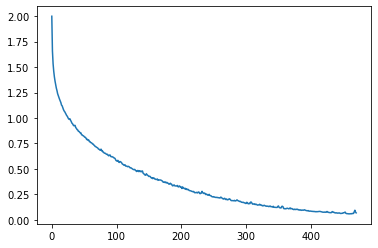

In [18]:
plt.plot(clf.loss_curve_)
plt.show()

### RandomSearchCV

In [19]:
'''
param_grid = {
    "hidden_layer_sizes": [(104,29), (55), (259), (253,131), (192)],
    "activation": ["relu", "tanh", "logistic"],
    "alpha": np.linspace(0.001,0.005,num=10),
    #"momentum": np.linspace(0,1,num=11),
    "learning_rate_init": np.linspace(0.001,0.01,num=11)
}
grid = RandomizedSearchCV(
    MLPClassifier(solver="adam",learning_rate="adaptive"),
    param_distributions=param_grid,
    scoring="accuracy",
    cv=RepeatedStratifiedKFold(random_state=0),
    n_jobs=-1,
    n_iter=500,
)
grid.fit(X_train, y_train)
clf = grid.best_params_
'''

'\nparam_grid = {\n    "hidden_layer_sizes": [(104,29), (55), (259), (253,131), (192)],\n    "activation": ["relu", "tanh", "logistic"],\n    "alpha": np.linspace(0.001,0.005,num=10),\n    #"momentum": np.linspace(0,1,num=11),\n    "learning_rate_init": np.linspace(0.001,0.01,num=11)\n}\ngrid = RandomizedSearchCV(\n    MLPClassifier(solver="adam",learning_rate="adaptive"),\n    param_distributions=param_grid,\n    scoring="accuracy",\n    cv=RepeatedStratifiedKFold(random_state=0),\n    n_jobs=-1,\n    n_iter=500,\n)\ngrid.fit(X_train, y_train)\nclf = grid.best_params_\n'

In [20]:
#grid.best_params_

### Best params: {'learning_rate_init': 0.0064,'hidden_layer_sizes': 259,'alpha': 0.003666666666666667,'activation': 'relu'}

In [21]:
clf = MLPClassifier(activation="relu", early_stopping=True, hidden_layer_sizes=(259), solver="adam", alpha=0.003666666666666667, learning_rate="adaptive", learning_rate_init=0.0064, random_state=0, max_iter=1000)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.44408427876823336
F1-score [0.48148148 0.55837563 0.40343348 0.38709677 0.33333333 0.50228311
 0.24657534 0.56      ]
              precision    recall  f1-score   support

           0       0.59      0.41      0.48        96
           1       0.51      0.62      0.56        89
           2       0.34      0.49      0.40        96
           3       0.40      0.38      0.39        48
           4       0.39      0.29      0.33        48
           5       0.45      0.57      0.50        96
           6       0.36      0.19      0.25        96
           7       0.54      0.58      0.56        48

    accuracy                           0.44       617
   macro avg       0.45      0.44      0.43       617
weighted avg       0.45      0.44      0.43       617



In [22]:
y_test_pred_proba = clf.predict_proba(X_test)

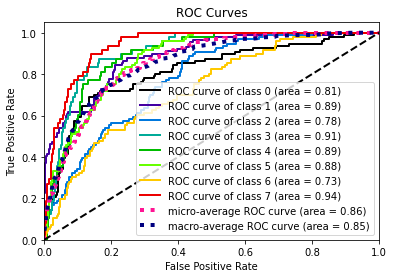

0.852806795556337


In [23]:
plot_roc(y_test, clf.predict_proba(X_test))
plt.show()
print(roc_auc_score(y_test, y_test_pred_proba, multi_class="ovr", average="macro"))

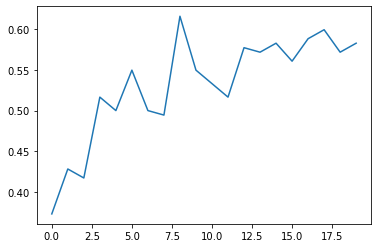

In [24]:
plt.plot(clf.validation_scores_)
plt.show()

### Keras

In [25]:
def build_model():
    
    model = Sequential()
    model.add(Dense(X_train.shape[1], input_dim=X_train.shape[1], activation='relu', kernel_regularizer=l2(0.02)))
    model.add(Dropout(0.05))
    model.add(Dense(259, activation='relu', kernel_regularizer=l2(0.02), kernel_constraint=MaxNorm(3)))
    model.add(Dropout(0.05))
    model.add(Dense(8, activation='softmax', kernel_regularizer=l2(0.02), kernel_constraint=MaxNorm(3)))

    model.compile(loss='sparse_categorical_crossentropy', 
                  optimizer="adam", weighted_metrics=['accuracy'])
    return model

In [26]:
es = EarlyStopping(monitor='val_accuracy', patience=100, verbose=True)
mc = ModelCheckpoint('best_model_NOREG.h5', monitor='val_accuracy', save_best_only=True)
clf = KerasClassifier(build_fn=build_model, 
                      callbacks=[es],
                      batch_size=128, optimizer="adam", class_weight="balanced")

NameError: name 'EarlyStopping' is not defined

In [ ]:
clf.fit(X_train, y_train, validation_split=0.2, epochs=500)

In [ ]:
history = clf.history_
plt.plot(history['accuracy'], label='Train')
plt.plot(history['val_accuracy'], label='Val')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
plt.plot(history['loss'], label='Train')
plt.plot(history['val_loss'], label='Val')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy')
plt.legend()
plt.show()

In [ ]:
y_pred = clf.predict(X_test).astype(int)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))